# Energy consumption prediction using LSTM/GRU in PyTorch

In [10]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

## Exploratory Data Analysis (EDA)

In [11]:
# Define data root directory
data_dir = "./new_data"
print(os.listdir(data_dir))

['korea_hourly_new.csv']


In [12]:
df = pd.read_csv(os.path.join(data_dir, "korea_hourly_new.csv"))
df.tail()

,Datetime,korea_MW
78139,2021-11-30 20:00,73662
78140,2021-11-30 21:00,71459
78141,2021-11-30 22:00,69255
78142,2021-11-30 23:00,67679
78143,2021-12-01 0:00,68181


## Create training instances by moving sliding window

In [13]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

## Integrate files to build the training set
To speed things up, I will only be using `num_files_for_dataset` .csv files for creating my dataset. Feel free to run it yourself with the entire dataset if you have the time and computing capacity. 

In [14]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(5)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 1

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}
train_x = []
test_x = {}
test_y = {}

In [15]:
# Skipping the files we're not using
processing_files = [file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"]
num_files_for_dataset = 1
print(processing_files)

['korea_hourly_new.csv']


In [17]:
for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, "korea_hourly_new.csv"), parse_dates=["Datetime"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
    df = df.sort_values("Datetime").drop("Datetime", axis=1)
    print("__________________")
    print(df["korea_MW"])
    print("------------------")

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/1 [00:00<?, ?it/s]

Processing korea_hourly_new.csv ...
__________________
0        60178
1        57862
2        56165
3        55135
4        54450
         ...  
78139    73662
78140    71459
78141    69255
78142    67679
78143    68181
Name: korea_MW, Length: 78144, dtype: int64
------------------
(77994, 150, 5) (77994, 1)


## What have we made?

In [8]:
train_x.shape

(70195, 150, 5)

In [9]:
test_x["korea_hourly_new.csv"].shape

(7799, 150, 5)

## Pytorch data loaders/generators

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The `TensorDataset` and `DataLoader` classes are useful for splitting our data into batches and shuffling them.

In [10]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [11]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (70195, 150, 5), Batch Size: 1024, # of iterations per epoch: 68


In [12]:
# release some memory
del train_x, train_y

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using "https://colab.research.google.com/" with GPU to run this code, the training time will be significantly reduced.

In [13]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

In [14]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        # print(out[:, -1].shape, h.shape)
        # select hidden state of last timestamp (t=90) (1024, 256)
        out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
        # print(out.shape) # (1024, 1)
        return out, h

    def init_hidden(self, batch_size):
        # Initialze h_0 with zeros
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        )
        return hidden


class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [15]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=10,
    model_type="GRU",
    print_every=100,
):

    input_dim = next(iter(train_loader))[0].shape[2]  # 5

    # Batch generator (train_data, train_label)
    # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            # Unpcak both h_0 and c_0
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])

            # Set the gradients to zero before starting to do backpropragation because
            # PyTorch accumulates the gradients on subsequent backward passes
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            # Perform backpropragation
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )
        current_time = time.process_time()

        print(
            f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}"
        )

        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

## Train and Save the GRU model

In [16]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 10
print_every = 100
lr = 0.001
gru_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="GRU",
    print_every=print_every,
)

Starting Training of GRU model
Epoch 1/10 Done, Total Loss: 0.016052243296358296
Time Elapsed for Epoch: 1762.359375 seconds
Epoch 2/10 Done, Total Loss: 0.0020467060881749015
Time Elapsed for Epoch: 1672.4375 seconds
Epoch 3/10 Done, Total Loss: 0.0014172523926176568
Time Elapsed for Epoch: 1727.75 seconds
Epoch 4/10 Done, Total Loss: 0.0010555280579651212
Time Elapsed for Epoch: 1799.875 seconds
Epoch 5/10 Done, Total Loss: 0.0007403755084584083
Time Elapsed for Epoch: 1762.4375 seconds
Epoch 6/10 Done, Total Loss: 0.000580741192714092
Time Elapsed for Epoch: 1745.5625 seconds
Epoch 7/10 Done, Total Loss: 0.00047870900915072793
Time Elapsed for Epoch: 1754.46875 seconds
Epoch 8/10 Done, Total Loss: 0.00041440899162005414
Time Elapsed for Epoch: 1829.875 seconds
Epoch 9/10 Done, Total Loss: 0.00038864224017529255
Time Elapsed for Epoch: 1826.90625 seconds
Epoch 10/10 Done, Total Loss: 0.0003496363334467306
Time Elapsed for Epoch: 1772.640625 seconds
Total Training Time: 17654.3125 sec

In [17]:
torch.save(gru_model.state_dict(), "./models/gru_model.pt")

## Train and Save an LSTM model

In [18]:
n_hidden = 256
n_layers = 2
n_epochs = 10
print_every = 100
lr = 0.001

lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

Starting Training of LSTM model
Epoch 1/10 Done, Total Loss: 0.022350735291290807
Time Elapsed for Epoch: 5469.828125 seconds
Epoch 2/10 Done, Total Loss: 0.003082609242376159
Time Elapsed for Epoch: 4565.46875 seconds
Epoch 3/10 Done, Total Loss: 0.0022151512282160934
Time Elapsed for Epoch: 2316.125 seconds
Epoch 4/10 Done, Total Loss: 0.0017749035340624258
Time Elapsed for Epoch: 2117.75 seconds
Epoch 5/10 Done, Total Loss: 0.0011149249279268963
Time Elapsed for Epoch: 2164.25 seconds
Epoch 6/10 Done, Total Loss: 0.00073704647451557
Time Elapsed for Epoch: 3479.203125 seconds
Epoch 7/10 Done, Total Loss: 0.000633386305279975
Time Elapsed for Epoch: 3930.25 seconds
Epoch 8/10 Done, Total Loss: 0.0005757016667356605
Time Elapsed for Epoch: 4510.125 seconds
Epoch 9/10 Done, Total Loss: 0.0005210648181245607
Time Elapsed for Epoch: 2230.921875 seconds
Epoch 10/10 Done, Total Loss: 0.00046893296701669255
Time Elapsed for Epoch: 2238.0 seconds
Total Training Time: 33021.921875 seconds


In [19]:
torch.save(lstm_model.state_dict(), "./models/lstm_model.pt")

As we can see from the training time of both models, the GRU model is the clear winner in terms of speed, as we have mentioned earlier. The GRU finished 5 training epochs faster than the LSTM model.

# Evaluating models
#### __Note: Running the following codes needs at least 16GB of memory.__
Moving on to measuring the accuracy of both models, we'll now use our `evaluate()` function and test dataset.

## Load the GRU model

In [20]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cpu"

In [21]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("./models/gru_model.pt"))

<All keys matched successfully>

In [22]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Load the LSTM model

In [23]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("./models/lstm_model.pt"))

<All keys matched successfully>

In [24]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Model Evaluation

For the purpose of comparing the performance of both models as well, we'll being tracking the time it takes for the model to train and eventually comparing the final accuracy of both models on the test set. For our accuracy measure, we'll use ***Symmetric Mean Absolute Percentage Error (sMAPE)*** to evaluate the models. *sMAPE* is the sum of the **absolute difference** between the predicted and actual values divided by the average of the predicted and actual value, therefore giving a percentage measuring the amount of error. 

This is the formula for *sMAPE*:

$sMAPE = \frac{100%}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|F_t + A_t|)/2}$

In [25]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [26]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

## Evaluate performance

In [27]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 74.15625
sMAPE: 0.432%


In [28]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 91.828125
sMAPE: 0.369%


While the GRU model may have made smaller errors and edged the LSTM model slightly in terms of performance accuracy, the difference is insignificant and thus inconclusive. There have been many other tests conducted by others comparing both these models but there has largely been no clear winner as to which is the better architecture overall.

# Some visualizations

Lastly, let's do some visualizations on random sets of our predicted output vs the actual consumption data for some states.

In [29]:
states_list = list(test_x.keys())

In [30]:
np.save('targets.npy', targets)
np.save('gru_outputs.npy', gru_outputs)
np.save('lstm_outputs.npy', lstm_outputs)

In [5]:
gru_output = np.load('gru_outputs.npy')
lstm_output = np.load('lstm_outputs.npy')
real = np.load('targets.npy')

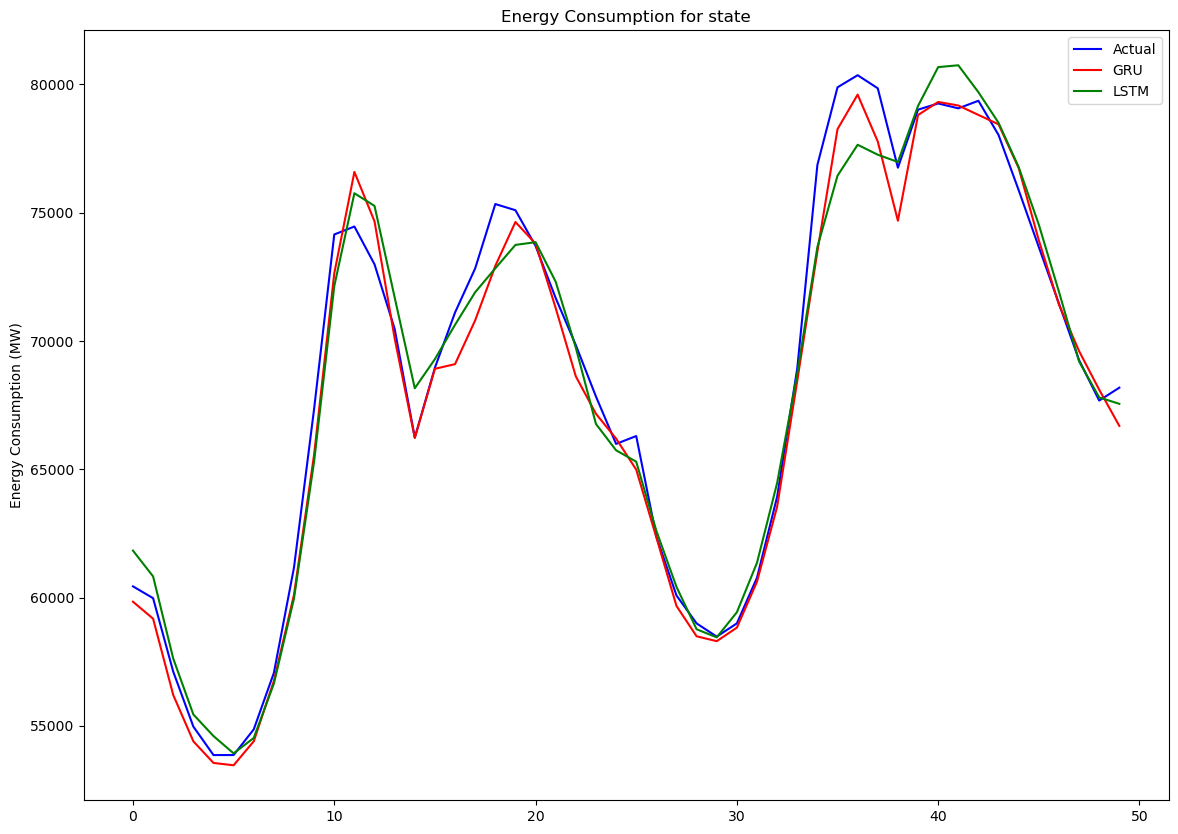

In [7]:
plt.figure(figsize=(14, 10))
plt.plot(real[0][-50:], color="b", label="Actual")
plt.plot(gru_output[0][-50:], color="r", label="GRU")
plt.plot(lstm_output[0][-50:], color="g", label="LSTM")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for state")
plt.legend()